## EDA Question: 
**How can we identify outliers and market anomalies using VIX and the S&P 500? And how can we track this sentiment to use it for specific stocks?**


Load the data...

In [81]:
# import the Libraries we will be using
import pandas as pd
import yfinance as yf
import ta
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import numpy as np
import sklearn as sk
import plotly as pl
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

In [82]:
# Load the data for VIX and the S&P 500 from yfinance

vix_raw = yf.download('^VIX')
sp500_raw = yf.download('^GSPC')
sp500_prices = yf.download('^GSPC', start='2007-01-01')


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


## 1. Identify any Problems with the Data. 
Scrutinize the data and determine if there are: missing values, variables represented with unsuitable data types, duplicates, unusual values.

In [83]:
# view the data
vix_raw.head()

Open       High        Low      Close  Adj Close  Volume
Date                                                                     
1990-01-02  17.240000  17.240000  17.240000  17.240000  17.240000       0
1990-01-03  18.190001  18.190001  18.190001  18.190001  18.190001       0
1990-01-04  19.219999  19.219999  19.219999  19.219999  19.219999       0
1990-01-05  20.110001  20.110001  20.110001  20.110001  20.110001       0
1990-01-08  20.260000  20.260000  20.260000  20.260000  20.260000       0

In [84]:
# view column properties
vix_raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8636 entries, 1990-01-02 to 2024-04-12
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       8636 non-null   float64
 1   High       8636 non-null   float64
 2   Low        8636 non-null   float64
 3   Close      8636 non-null   float64
 4   Adj Close  8636 non-null   float64
 5   Volume     8636 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 472.3 KB


In [85]:
# check for missing values
vix_raw.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

There are no missing values in the vix dataset, so it is safe to proceed!

In [86]:
# view the data
sp500_raw.head()

Open       High        Low      Close  Adj Close  Volume
Date                                                                     
1927-12-30  17.660000  17.660000  17.660000  17.660000  17.660000       0
1928-01-03  17.760000  17.760000  17.760000  17.760000  17.760000       0
1928-01-04  17.719999  17.719999  17.719999  17.719999  17.719999       0
1928-01-05  17.549999  17.549999  17.549999  17.549999  17.549999       0
1928-01-06  17.660000  17.660000  17.660000  17.660000  17.660000       0

In [87]:
# view column properties
sp500_raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24186 entries, 1927-12-30 to 2024-04-12
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       24186 non-null  float64
 1   High       24186 non-null  float64
 2   Low        24186 non-null  float64
 3   Close      24186 non-null  float64
 4   Adj Close  24186 non-null  float64
 5   Volume     24186 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 1.3 MB


In [88]:
# check for missing values
sp500_raw.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

There are no missing values in the s&p500 dataset, so it is safe to proceed!

Since both datasets are important financial indicators that heavily regulated and strictly maintained, there is no surprise that the data is "perfect" and accurate. However, there are still steps we can take to prepare the data and create our features for our ML model. 

## 2. Clean and Prepare the Data. 

We will create a singular df that takes data that we collect from yfinance as well as data we will create.

In [89]:
# append column for change in high and low prices, compared to low price for VIX
vix_raw['High_Low_Change'] = (vix_raw['High'] - vix_raw['Low']) / vix_raw['Low']

# append column for change in open and close prices, compared to low price for S&P 500
vix_raw['Open_Close_Change'] = (vix_raw['Close'] - vix_raw['Open']) / vix_raw['Open']

vix_raw.head()


Open       High        Low      Close  Adj Close  Volume  \
Date                                                                        
1990-01-02  17.240000  17.240000  17.240000  17.240000  17.240000       0   
1990-01-03  18.190001  18.190001  18.190001  18.190001  18.190001       0   
1990-01-04  19.219999  19.219999  19.219999  19.219999  19.219999       0   
1990-01-05  20.110001  20.110001  20.110001  20.110001  20.110001       0   
1990-01-08  20.260000  20.260000  20.260000  20.260000  20.260000       0   

            High_Low_Change  Open_Close_Change  
Date                                            
1990-01-02              0.0                0.0  
1990-01-03              0.0                0.0  
1990-01-04              0.0                0.0  
1990-01-05              0.0                0.0  
1990-01-08              0.0                0.0

This gives us a better representation of what is occuring between the high and low price, as well as the open and close price, on an intraday skill.

In [90]:
# append column for change in high and low prices for S&P 500
sp500_raw['High_Low_Change'] = (sp500_raw['High'] - sp500_raw['Low']) / sp500_raw['Low']

# append column for change in open and close prices for S&P 500
sp500_raw['Open_Close_Change'] = (sp500_raw['Close'] - sp500_raw['Open']) / sp500_raw['Open']

sp500_raw.head()


Open       High        Low      Close  Adj Close  Volume  \
Date                                                                        
1927-12-30  17.660000  17.660000  17.660000  17.660000  17.660000       0   
1928-01-03  17.760000  17.760000  17.760000  17.760000  17.760000       0   
1928-01-04  17.719999  17.719999  17.719999  17.719999  17.719999       0   
1928-01-05  17.549999  17.549999  17.549999  17.549999  17.549999       0   
1928-01-06  17.660000  17.660000  17.660000  17.660000  17.660000       0   

            High_Low_Change  Open_Close_Change  
Date                                            
1927-12-30              0.0                0.0  
1928-01-03              0.0                0.0  
1928-01-04              0.0                0.0  
1928-01-05              0.0                0.0  
1928-01-06              0.0                0.0

In [91]:
# Calculate the Relative Strength Index for the S&P 500
sp500_raw['RSI'] = ta.momentum.rsi(close=sp500_raw['Adj Close'], window=14, fillna=True)
sp500_raw.head()

Open       High        Low      Close  Adj Close  Volume  \
Date                                                                        
1927-12-30  17.660000  17.660000  17.660000  17.660000  17.660000       0   
1928-01-03  17.760000  17.760000  17.760000  17.760000  17.760000       0   
1928-01-04  17.719999  17.719999  17.719999  17.719999  17.719999       0   
1928-01-05  17.549999  17.549999  17.549999  17.549999  17.549999       0   
1928-01-06  17.660000  17.660000  17.660000  17.660000  17.660000       0   

            High_Low_Change  Open_Close_Change         RSI  
Date                                                        
1927-12-30              0.0                0.0  100.000000  
1928-01-03              0.0                0.0  100.000000  
1928-01-04              0.0                0.0   69.892072  
1928-01-05              0.0                0.0   29.391291  
1928-01-06              0.0                0.0   49.701726

The Relative Strength Index, or RSI, is an oscillating indicator that is designed to measure a stock's momentum, which is both the speed and size of price changes.

In [92]:
# Calculate the Detrended Price Oscillator for the S&P 500
sp500_raw['DPO'] = ta.trend.dpo(close=sp500_raw['Adj Close'], window=20)
sp500_raw.head()

Open       High        Low      Close  Adj Close  Volume  \
Date                                                                        
1927-12-30  17.660000  17.660000  17.660000  17.660000  17.660000       0   
1928-01-03  17.760000  17.760000  17.760000  17.760000  17.760000       0   
1928-01-04  17.719999  17.719999  17.719999  17.719999  17.719999       0   
1928-01-05  17.549999  17.549999  17.549999  17.549999  17.549999       0   
1928-01-06  17.660000  17.660000  17.660000  17.660000  17.660000       0   

            High_Low_Change  Open_Close_Change         RSI  DPO  
Date                                                             
1927-12-30              0.0                0.0  100.000000  NaN  
1928-01-03              0.0                0.0  100.000000  NaN  
1928-01-04              0.0                0.0   69.892072  NaN  
1928-01-05              0.0                0.0   29.391291  NaN  
1928-01-06              0.0                0.0   49.701726  NaN

The detrended price oscillator seeks to help a trader identify an asset's price cycle. It does this by comparing an SMA to a historical price that is near the middle of the look-back period.

In [93]:
# add pring special k indicator
short_roc = ta.momentum.ROCIndicator(close=sp500_raw['Close'], window=10).roc() * 1
intermediate_roc = ta.momentum.ROCIndicator(close=sp500_raw['Close'], window=15).roc() * 2
medium_roc = ta.momentum.ROCIndicator(close=sp500_raw['Close'], window=20).roc() * 3
long_roc = ta.momentum.ROCIndicator(close=sp500_raw['Close'], window=30).roc() * 4
longer_roc = ta.momentum.ROCIndicator(close=sp500_raw['Close'], window=40).roc() * 1
very_long_roc = ta.momentum.ROCIndicator(close=sp500_raw['Close'], window=65).roc() * 1

sp500_raw['PSK'] = short_roc + intermediate_roc + medium_roc + long_roc + longer_roc + very_long_roc

The Pring Special K is a momentum indicator created by Martin Pring. It's a complex indicator that combines short, intermediate, and long-term market momentum. It uses these differing rate-of-change (ROC) calculations to gauge market momentum over differing time frames.

Now that we have the all the data collected, we will merge the dataframes into one main DF while removing the rows we don't need.

In [94]:
# Drop Open, High, Low, Close, and Adj Close columns for S&P 500
sp500_raw = sp500_raw.drop(columns=['Open', 'High', 'Low', 'Close', 'Adj Close'])
sp500_raw.head()

Volume  High_Low_Change  Open_Close_Change         RSI  DPO  PSK
Date                                                                        
1927-12-30       0              0.0                0.0  100.000000  NaN  NaN
1928-01-03       0              0.0                0.0  100.000000  NaN  NaN
1928-01-04       0              0.0                0.0   69.892072  NaN  NaN
1928-01-05       0              0.0                0.0   29.391291  NaN  NaN
1928-01-06       0              0.0                0.0   49.701726  NaN  NaN

In [95]:
# Drop the open, high, low, close, and volume columns for VIX
vix_raw = vix_raw.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'])
vix_raw.head()

Close  High_Low_Change  Open_Close_Change
Date                                                     
1990-01-02  17.240000              0.0                0.0
1990-01-03  18.190001              0.0                0.0
1990-01-04  19.219999              0.0                0.0
1990-01-05  20.110001              0.0                0.0
1990-01-08  20.260000              0.0                0.0

In [96]:
# Keep only the adjusted close column for the S&P 500
sp500_prices = sp500_prices.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume'])
sp500_prices.head()

Adj Close
Date                   
2007-01-03  1416.599976
2007-01-04  1418.339966
2007-01-05  1409.709961
2007-01-08  1412.839966
2007-01-09  1412.109985

This df won't be used for training but rather to plot our data points against the historical prices.

In [97]:
# Set the data frames to start from 2007-01-01
vix_raw = vix_raw.loc['2007-01-01':]
sp500_raw = sp500_raw.loc['2007-01-01':]
sp500_prices = sp500_prices.loc['2007-01-01':]

In [98]:
# rename the columns for the S&P 500 and Vix raw set to indentify them
vix_raw.columns = ['VIX_Close', 'VIX_High_Low_Change', 'VIX_Open_Close_Change']
sp500_raw.columns = ['SP500_Volume','SP500_High_Low_Change', 'SP500_Open_Close_Change', 'SP500_RSI', 'SP500_DPO', 'SP500_PSK']
sp500_prices.columns = ['SP500_Adj_Close']

In [99]:
# merge the raw df into one main dataset
df = pd.concat([vix_raw, sp500_raw], axis=1)
df.head()

VIX_Close  VIX_High_Low_Change  VIX_Open_Close_Change  \
Date                                                                
2007-01-03      12.04             0.105811              -0.009868   
2007-01-04      11.51             0.101064              -0.071774   
2007-01-05      12.14             0.048801               0.025338   
2007-01-08      12.00             0.089134              -0.038462   
2007-01-09      11.91             0.066724               0.004216   

            SP500_Volume  SP500_High_Low_Change  SP500_Open_Close_Change  \
Date                                                                       
2007-01-03    3429160000               0.015314                -0.001008   
2007-01-04    3004460000               0.009521                 0.001228   
2007-01-05    2919400000               0.008956                -0.006085   
2007-01-08    2763340000               0.007842                 0.002540   
2007-01-09    3038380000               0.007250                -0.000517   

            SP500_RSI  SP500_DPO  SP500_PSK  
Date                                         
2007-01-03  54.191874   8.075482  18.715809  
2007-01-04  55.405032   9.214459  17.451071  
2007-01-05  48.538882   4.856976   8.243647  
2007-01-08  50.914810   7.930048  10.114638  
2007-01-09  50.331174   5.669031   6.916034

In [100]:
# add log rates to the s&p500 dataset
sp500_prices['Log_Price'] = np.log(sp500_prices['SP500_Adj_Close'])

In [101]:
# now get daily percent change
sp500_prices['PCT_Change'] = sp500_prices['SP500_Adj_Close'].pct_change()

In [102]:
# start dataset from 2010
sp500_prices = sp500_prices.loc['2011-01-01':]
df = df.loc['2011-01-01':]

## 3. Hypothesis Testing

We will conduct a hypothesis test to see what is the best approach to handle our data.

In [103]:
import scipy.stats as stats
import random
import plotly.graph_objects as go
# pick two random years
# make a list of years from 2011 to 2023
years = [str(year) for year in range(2011, 2024)]
# do a hypothesis test to see if s&p500 prices in year 1 and year 2 are correlated
year_1 = random.choice(years)
years.remove(year_1)
year_2 = random.choice(years)

sp500_prices_1 = sp500_prices.loc[f'{year_1}-01-01':f'{year_1}-12-31']
sp500_prices_2 = sp500_prices.loc[f'{year_2}-01-01':f'{year_2}-12-31']
sp500_prices_1 = sp500_prices_1.reset_index()
sp500_prices_2 = sp500_prices_2.reset_index()

# create the t-test
ttest_result = stats.ttest_ind(sp500_prices_1['PCT_Change'], sp500_prices_2['PCT_Change'], nan_policy='omit')

# print the p-value 
print('Hypothetical test to see if the S&P 500 prices in', year_1, 'and', year_2, 'are correlated')
print("The p-value is: ", ttest_result.pvalue)

if ttest_result.pvalue < 0.05:
    print("The null hypothesis is rejected.")
else:
    print("The null hypothesis is accepted.")
    print("There is not enough evidence to prove that the two years are correlated.")

pl.io.templates.default = "plotly_dark"

# Your dataframes after resetting the index
sp500_prices_1_reset = sp500_prices_1.reset_index(drop=True)
sp500_prices_2_reset = sp500_prices_2.reset_index(drop=True)

# Plot year 1
fig = px.scatter(sp500_prices_1_reset, x=sp500_prices_1_reset.index + 1, y='PCT_Change', 
                 title='S&P 500 Price Change Comparison')

# Add year 1 and year 2 data to the plot with names for the legend
fig.add_trace(
    go.Scatter(
        x=sp500_prices_1_reset.index + 1, 
        y=sp500_prices_1_reset['PCT_Change'], 
        mode='markers', 
        name=year_1
    )
)
fig.add_trace(
    go.Scatter(
        x=sp500_prices_2_reset.index + 1, 
        y=sp500_prices_2_reset['PCT_Change'], 
        mode='markers', 
        name=year_2
    )
)

# Update x-axis title
fig.update_layout(xaxis_title="Days")

# Ensure the legend is shown
fig.update_layout(showlegend=True)

fig.show()

Hypothetical test to see if the S&P 500 prices in 2018 and 2023 are correlated
The p-value is:  0.19890721963640778
The null hypothesis is accepted.
There is not enough evidence to prove that the two years are correlated.


Since the null hypthoesis is accepted taking two completely random years, there is no correlation or pattern in price. It is clear that we could perform an unsupervised ML model to extract outliers and hopefully derive a pattern from this dataset.

The second hypothesis test will be between the price change % and the vix (a feature we will be using to train our dataset)

In [104]:
import scipy.stats as stats
import plotly.graph_objects as go

sp500_prices_2015 = sp500_prices.loc['2015-01-01':'2015-12-31']
vix_2015 = df.loc['2015-01-01':'2015-12-31']

# create the t-test
ttest_result = stats.ttest_ind(sp500_prices_2015['PCT_Change'], vix_2015['VIX_Close'], nan_policy='omit')

# print the p-value
print('Hypothetical test to see if the S&P 500 prices and VIX close are correlated')
print("The p-value is: ", ttest_result.pvalue)

if ttest_result.pvalue < 0.05:
    print("The null hypothesis is rejected.")

# plot the data on two different y scales on y scale on the right and one on the left
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=sp500_prices_2015.index, y=sp500_prices_2015['PCT_Change'], name='S&P 500 Price Change'))
fig.add_trace(go.Scatter(x=vix_2015.index, y=vix_2015['VIX_Close'], name='VIX Close', yaxis='y2'))

# Create axis objects
fig.update_layout(
    title='S&P 500 Price Change and VIX Close Comparison',
    xaxis_title='Date',
    yaxis=dict(
        title='S&P 500 Price Change'
    ),
    yaxis2=dict(
        title='VIX Close',
        overlaying='y',
        side='right'
    )
)

fig.show()


Hypothetical test to see if the S&P 500 prices and VIX close are correlated
The p-value is:  1.739683326829587e-234
The null hypothesis is rejected.


Since the correlation between price change % and VIX seems to be significant as the p-value is less than 0.05, it makes sense to train our ML model on these features that we create. 

## 4. Summarize and Visualize the Data. 

In [105]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create a figure with 2 rows
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.02)

# Add line for VIX Close to the first subplot
fig.add_trace(go.Scatter(x=df.index, y=df['VIX_Close'], name='VIX Close'), row=1, col=1)

# Add line for High_Low_Change to the second subplot
fig.add_trace(go.Scatter(x=df.index, y=df['VIX_High_Low_Change'], name='High_Low_Change'), row=2, col=1)

# Add line for Open_Close_Change to the second subplot
fig.add_trace(go.Scatter(x=df.index, y=df['VIX_Open_Close_Change'], name='Open_Close_Change'), row=2, col=1)

# Update layout
fig.update_layout(title='VIX Price and Change',
                  yaxis_title='Price',
                  xaxis2_title='Date', 
                  yaxis2_title='Change') 

# Update y-axes of the second subplot if necessary, for example, to change the range or the scale

fig.show()

In the visualization above, we plot the closing prices of the VIX index, followed by a plot demonstrating the changes in the daily high and low prices, as well as the open and closing prices. This also serves to verify the accuracy of our data, where we see similar movements across both graphs (ex: peak before 2015, peak after 2020)

In [106]:
# Create a figure with 2 rows
fig2 = make_subplots(rows=4, cols=1, shared_xaxes=True, vertical_spacing=0.02)

# Add line for S&P Close to the first subplot
fig2.add_trace(go.Scatter(x=sp500_prices.index, y=sp500_prices['SP500_Adj_Close'], name='S&P500 Close'), row=1, col=1)

# Add line for High_Low_Change to the second subplot
fig2.add_trace(go.Scatter(x=df.index, y=df['SP500_High_Low_Change'], name='High_Low_Change'), row=2, col=1)

# Add line for Open_Close_Change to the second subplot
fig2.add_trace(go.Scatter(x=df.index, y=df['SP500_Open_Close_Change'], name='Open_Close_Change'), row=2, col=1)

# Add line for RSI to the third subplot
fig2.add_trace(go.Scatter(x=df.index, y=df['SP500_RSI'], name='RSI'), row=3, col=1)

# Add line for DPO to the fourth subplot
fig2.add_trace(go.Scatter(x=df.index, y=df['SP500_DPO'], name='DPO'), row=4, col=1)

# Update layout
fig2.update_layout(title='Closing Price, Change, & RSI of the S&P 500',
                  yaxis_title='Price',
                  xaxis_title='Date', 
                  yaxis2_title='Change',
                  yaxis3_title='Value',
                  yaxis4_title='Value') 

# Update y-axes of the second subplot if necessary, for example, to change the range or the scale

fig2.show()

The visualization plots data and values for the S&P500 - it includes the closing prices, high-low and open-close prices, RSI values, and DPO values.

The graph supports the accuracy and completeness of our data, where there are no gaps. Additionally, the accuracy is supported by the matching patterns, where spikes in prices have corresponding spikes/changes in other measures below.

In [107]:
# displays first 5 rows of the dataset

df.head()

VIX_Close  VIX_High_Low_Change  VIX_Open_Close_Change  \
Date                                                                
2011-01-03  17.610001             0.061502              -0.018395   
2011-01-04  17.379999             0.052510               0.002307   
2011-01-05  17.020000             0.064650              -0.044357   
2011-01-06  17.400000             0.045861               0.035714   
2011-01-07  17.139999             0.090525              -0.009821   

            SP500_Volume  SP500_High_Low_Change  SP500_Open_Close_Change  \
Date                                                                       
2011-01-03    4286670000               0.014750                 0.011331   
2011-01-04    4796420000               0.009076                -0.002160   
2011-01-05    4764920000               0.009697                 0.006132   
2011-01-06    4844100000               0.006092                -0.001912   
2011-01-07    4963110000               0.011992                -0.002283   

            SP500_RSI  SP500_DPO  SP500_PSK  
Date                                         
2011-01-03  75.531546  -3.786005  59.614744  
2011-01-04  73.633646  -5.099963  56.124090  
2011-01-05  76.096958  -4.570544  63.246629  
2011-01-06  72.968657   0.670978  64.847787  
2011-01-07  70.271023   2.985968  53.509981

## 5. Create the ML Models
    #1 Isolation Forest

Isolation Forest is an algorithm used for anomaly detection. It identifies outliers or anomalies in the data by isolating observations. 

In [108]:
# create isolation forest model
model = IsolationForest(contamination=0.02, random_state=42)
# create a copy of the dataframe
df_copy = df.copy()

# remove SP500 high low change and open close change
df_copy = df_copy.drop(columns=['SP500_High_Low_Change', 'SP500_Open_Close_Change'])

# remove the year 2020
df_copy = df_copy.loc[(df_copy.index.year != 2020)]
sp500_prices2 = sp500_prices.copy()
sp500_prices = sp500_prices.loc[(sp500_prices.index.year != 2020)]

# fit the model on the original features
model.fit(df_copy)

# append the anomaly scores to the dataframe
df_copy['Anomaly_Score'] = model.decision_function(df_copy)

# Predict anomalies using the original features
df_copy['anomaly'] = model.predict(df_copy.drop(columns=['Anomaly_Score']))


Here, we create an Isolation Forest model to detect anomalies in the data, with certain columns dropped and data for the year 2020 removed. The model is then fitted, and anomaly scores and predictions are added to the dataframe.

In [109]:
# plot the anomaly scores against the sp500 close price
# plot data points of outliers highlighted in red against using time as the x-axis and sp500 close as the y-axis
pl.io.templates.default = "plotly_dark"
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_copy.index, y=sp500_prices['SP500_Adj_Close'], mode='lines', name='Normal', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=df_copy[df_copy['anomaly'] == -1].index, y=sp500_prices['SP500_Adj_Close'][df_copy['anomaly'] == -1], mode='markers', name='Anomaly', marker=dict(color='red')))
fig.update_layout(title='S&P 500 Anomalies in Isolation Forest', xaxis_title='Date', yaxis_title='S&P 500 Close', legend_title="Data Type")
fig.show()

Here, we plot the adjusted close prices of the S&P 500, highlighting anomalies detected by the Isolation Forest model. Anomalies are shown as red markers on the plot, contrasting with the normal price movements.

In [110]:
# plot the anomaly scores against the sp500 log close price
pl.io.templates.default = "plotly_dark"
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_copy.index, y=sp500_prices['Log_Price'], mode='lines', name='Normal', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=df_copy[df_copy['anomaly'] == -1].index, y=sp500_prices['Log_Price'][df_copy['anomaly'] == -1], mode='markers', name='Anomaly', marker=dict(color='red')))
fig.update_layout(title='S&P 500 Anomalies Log scale', xaxis_title='Date', yaxis_title='S&P 500 Log Close', legend_title="Data Type")
fig.show()

This section of code visualizes anomalies (in red) against the logarithmic close prices of the S&P 500 (blue)

In [111]:
# plot the anomaly scores against daily percent change
pl.io.templates.default = "plotly_dark"
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_copy.index, y=sp500_prices['PCT_Change'], mode='lines', name='Normal', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=df_copy[df_copy['anomaly'] == -1].index, y=sp500_prices['PCT_Change'][df_copy['anomaly'] == -1], mode='markers', name='Anomaly', marker=dict(color='red')))
fig.update_layout(title='S&P 500 Anomalies over Price Change', xaxis_title='Date', yaxis_title='Percent Change', legend_title="Type")
fig.show()

This section of code visualizes anomalies (in red) from the Isolation Forest model against the daily percentage changes in the S&P 500 prices

In [112]:
# calculate the percent of flips in the anomalies
percents = pd.DataFrame()
for i in range(len(df_copy)):
    percents['PCT_Change'] = sp500_prices['PCT_Change']
    percents['Next_PCT_Change'] = sp500_prices['PCT_Change'].shift(-1)
    percents['Anomaly'] = df_copy['anomaly']

# drop rows where anomaly is not -1
percents = percents[percents['Anomaly'] == -1]

# if the percent change flips put 1 else put 0
percents['Flip'] = np.where(percents['PCT_Change'] * percents['Next_PCT_Change'] < 0, 1, 0)

# sum the flips out of total anomalies
flips = percents['Flip'].sum()
total = percents['Flip'].count()
print(f'flips: {flips} out of {total} anomalies')
# print percent flips
print(f'percent flips: {flips/total}')

flips: 33 out of 62 anomalies
percent flips: 0.532258064516129


Here, we calculate the "flips" in anomalies, where a flip is defined as a change in the direction of the percentage change from one day to the next. It quantifies the number of these flips in the identified anomalies

In [113]:
import itertools
# tune hyperparameters to find the best model


param_grid = {
    'n_estimators': [25, 50, 100, 200],
    'max_samples': [0.5, 0.8, 1.0],
    'contamination': [0.05, 0.06, 0.07, 0.08, 0.09, 0.1],
    'max_features': [0.5, 0.8, 1.0],
    'bootstrap': [True, False]
}

# Generate all combinations of parameters
keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

best_ratio = 0
best_params = None
best_flips = 0
best_total_anomalies = 0
anomaly_filtered_iso = None

# Finds the best parameters
for params in param_combinations:
    model = IsolationForest(**params, random_state=42, n_jobs=-1)
    model.fit(df_copy)

    predicted_anomalies = model.predict(df_copy)

    # calculate the percent of flips in the anomalies
    percents = pd.DataFrame()
    percents['PCT_Change'] = sp500_prices['PCT_Change']
    percents['Next_PCT_Change'] = sp500_prices['PCT_Change'].shift(-1)
    percents['Anomaly'] = predicted_anomalies
    anomaly_filtered = percents[percents['Anomaly'] == -1].copy()
    anomaly_filtered['Flip'] = np.where(anomaly_filtered['PCT_Change'] * anomaly_filtered['Next_PCT_Change'] < 0, 1, 0)

    # sum the flips out of total anomalies
    flips = anomaly_filtered['Flip'].sum()
    total = anomaly_filtered['Flip'].count()
    ratio = flips / total if total > 0 else 0

    # update the best parameters if the current parameters are better
    if ratio > best_ratio:
        best_ratio = ratio
        best_params = params
        best_flips = flips
        best_total_anomalies = total
        anomaly_filtered_iso = anomaly_filtered

# After finding the best parameters, fit the model again and update df_copy
best_model = IsolationForest(**best_params, random_state=42, n_jobs=-1)
best_model.fit(df_copy)
df_copy['anomaly'] = np.where(best_model.predict(df_copy) == -1, -1, 0)

print("Best parameters:", best_params)
print("Best flips/total anomalies ratio:", best_ratio)
print("Total flips:", best_flips)
print("Total anomalies detected:", best_total_anomalies)
iso_flips = best_flips
iso_anomalies = best_total_anomalies
df_iso = df_copy.copy()

ValueError: Length of values (3088) does not match length of index (3087)

The section of code above identifies the best parameters for the model's performance, and the model is retrained with these parameters to finalize the anomaly detection model.

In [ ]:
# graph the anomly scores against the percent change
pl.io.templates.default = "plotly_dark"
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_copy.index, y=sp500_prices['PCT_Change'], mode='lines', name='Normal', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=df_copy[df_copy['anomaly'] == -1].index, y=sp500_prices['PCT_Change'][df_copy['anomaly'] == -1], mode='markers', name='Anomaly', marker=dict(color='red')))
fig.update_layout(title='S&P 500 Anomalies over Price Change using best IF', xaxis_title='Date', yaxis_title='Percent Change', legend_title="Type")
fig.show()


The anomalies detected by the adjusted, best model are visualized against the percentage change in the S&P 500

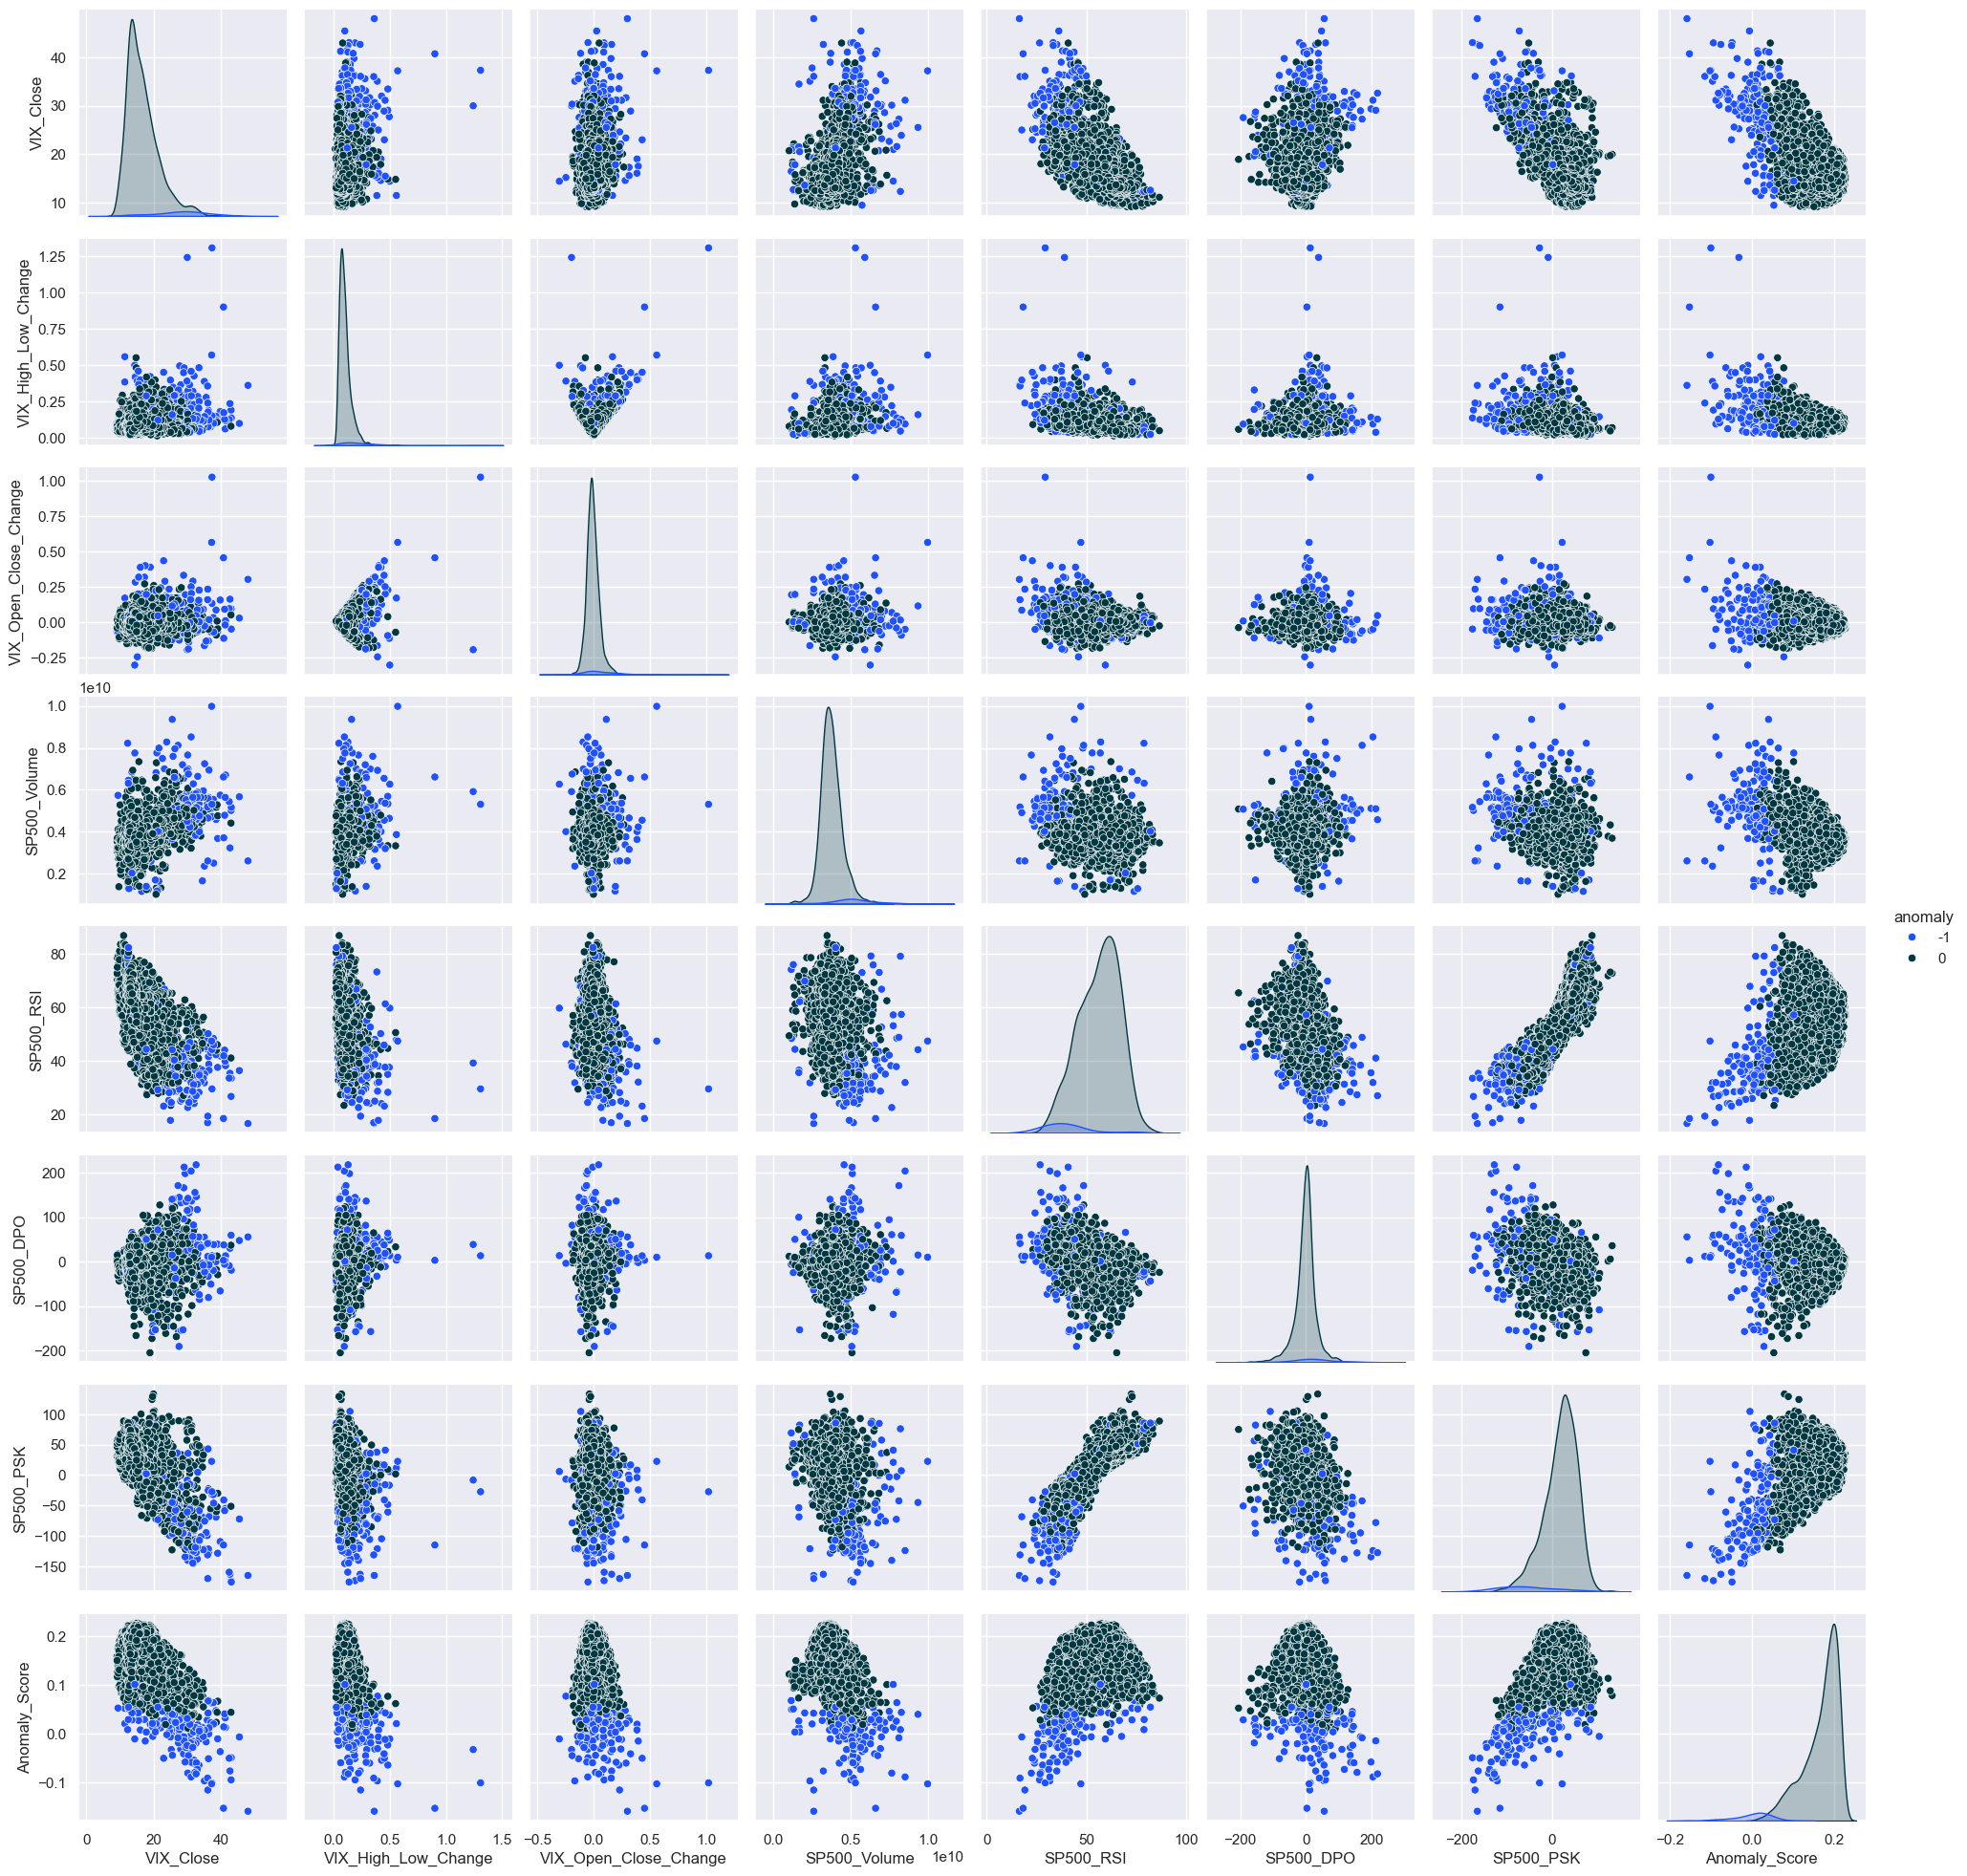

In [ ]:
# pairplot with anomaly scores switch colors
sns.set(style="darkgrid")
palette = {-1: "#1F51FF", 0: "#003741"}
sns.pairplot(df_copy, hue='anomaly', palette=palette)

Here, we use the pairplot function to create a grid of plots showing the relationships between different variables in the data, with the data points colored based on whether they are anomalies or not. The anomalies are shown in the royal blue color, with the remaining points represented by the dark green markers.

    #2 Local Outlier Factor (LOF)

In [ ]:
# import local outlier factor
from sklearn.neighbors import LocalOutlierFactor

# create local outlier factor model
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)

# make a copy of the dataframe
df_copy2 = df.copy()

# remove SP500 high low change and open close change
df_copy2 = df_copy2.drop(columns=['SP500_High_Low_Change', 'SP500_Open_Close_Change'])

# remove the year 2020
df_copy2 = df_copy2.loc[(df_copy2.index.year != 2020)]
sp500_prices2 = sp500_prices.copy()
sp500_prices = sp500_prices.loc[(sp500_prices.index.year != 2020)]

# fit the model on the original features
lof.fit(df_copy2)

# append the anomaly scores to the dataframe
df_copy2['Anomaly_Score'] = lof.negative_outlier_factor_
threshold = np.quantile(df_copy2['Anomaly_Score'], 0.1)
df_copy2['Anomaly'] = (df_copy2['Anomaly_Score'] < threshold).astype(int) * -1 + (df_copy2['Anomaly_Score'] >= threshold).astype(int) * 0


For our second model, we create an LocalOutlierFactor (LOF) model to detect anomalies, once again with certain columns dropped and data for the year 2020 removed. The model is then fitted, anomaly scores are calculated, and a threshold is set to determine which points are anomalies.

In [ ]:
# plot the anomaly scores against the sp500 change price
pl.io.templates.default = "plotly_dark"
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_copy2.index, y=sp500_prices2['PCT_Change'], mode='lines', name='Normal', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=df_copy2[df_copy2['Anomaly'] == -1].index, y=sp500_prices['PCT_Change'][df_copy2['Anomaly'] == -1], mode='markers', name='Anomaly', marker=dict(color='red')))
fig.update_layout(title='S&P 500 Anomalies Over Price Change', xaxis_title='Date', yaxis_title='Percent Change', legend_title="Type")
fig.show()


This section of code visualizes anomalies (in red) from the LOF model against the daily percentage changes in the S&P 500 prices

In [ ]:
# calculate the percent of flips in the anomalies
percents2 = pd.DataFrame()
for i in range(len(df_copy2)):
    percents2['PCT_Change'] = sp500_prices['PCT_Change']
    percents2['Next_PCT_Change'] = sp500_prices['PCT_Change'].shift(-1)
    percents2['Anomaly'] = df_copy2['Anomaly']

# drop rows where anomaly is not -1
percents2 = percents2[percents2['Anomaly'] == -1]

# if the percent change flips put 1 else put 0
percents2['Flip'] = np.where(percents2['PCT_Change'] * percents2['Next_PCT_Change'] < 0, 1, 0)

# sum the flips out of total anomalies
flips2 = percents2['Flip'].sum()
total2 = percents2['Flip'].count()
print(f'flips: {flips2} out of {total2} anomalies')
# print percent flips
print(f'percent flips: {flips2/total2}')


flips: 173 out of 309 anomalies
percent flips: 0.5598705501618123


Here, we calculate the number of flips in the anomalies detected by the LOF model, similar to the previous analysis with the Isolation Forest. 

In [ ]:
import itertools
# tune hyperparameters to find the best model


param_grid = {
    'n_neighbors': [20, 25, 50, 100, 200],
    'contamination': [0.05, 0.06, 0.07, 0.08, 0.09, 0.1],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 20, 30, 40, 50]
}

# Generate all combinations of parameters
keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

best_ratio = 0
best_params = None
best_flips = 0
best_total_anomalies = 0
anomaly_filtered_lof = None

for params in param_combinations:
    # Create and fit the LOF model with the current set of parameters
    model = LocalOutlierFactor(**params, n_jobs=-1)
    model.fit(df_copy2)
    
    # Get the negative outlier factor scores
    anomaly_scores = model.negative_outlier_factor_
    
    # Compute the threshold based on the contamination rate
    threshold = np.quantile(anomaly_scores, params['contamination'])
    
    # Determine if each data point is an anomaly
    anomalies = (anomaly_scores < threshold).astype(int)
    
    # Prepare the dataframe for the flip analysis
    percents2 = pd.DataFrame()
    percents2['PCT_Change'] = sp500_prices['PCT_Change']
    percents2['Next_PCT_Change'] = sp500_prices['PCT_Change'].shift(-1)
    percents2['Anomaly'] = anomalies
    
    # Filter the dataframe for anomalies and calculate flips
    anomaly_filtered = percents2[percents2['Anomaly'] == 1].copy()
    anomaly_filtered['Flip'] = np.where(anomaly_filtered['PCT_Change'] * anomaly_filtered['Next_PCT_Change'] < 0, 1, 0)

    flips = anomaly_filtered['Flip'].sum()
    total = anomaly_filtered['Anomaly'].sum()  # Since anomalies are marked with 1, this is the total count
    ratio = flips / total if total > 0 else 0

    # Update the best parameters if the current ratio is the best
    if ratio > best_ratio:
        best_ratio = ratio
        best_params = params
        best_flips = flips
        best_total_anomalies = total
        anomaly_filtered_lof = anomaly_filtered

# After finding the best parameters, create and fit the final LOF model
best_model = LocalOutlierFactor(**best_params, n_jobs=-1)
best_model.fit(df_copy2)

# Assign anomaly labels based on the best model's threshold
best_threshold = np.quantile(best_model.negative_outlier_factor_, best_params['contamination'])
df_copy2['Anomaly'] = (best_model.negative_outlier_factor_ < best_threshold).astype(int)

print("Best parameters:", best_params)
print("Best flips/total anomalies ratio:", best_ratio)
print("Total flips:", best_flips)
print("Total anomalies detected:", best_total_anomalies)
lof_flips = best_flips
lof_anomalies = best_total_anomalies
df_lof = df_copy2.copy()



Best parameters: {'n_neighbors': 20, 'contamination': 0.05, 'algorithm': 'auto', 'leaf_size': 10}
Best flips/total anomalies ratio: 0.6
Total flips: 93
Total anomalies detected: 155


The section of code above identifies the best parameters for the LOF model's performance, and the model is retrained with these parameters to finalize the anomaly detection model.

In [ ]:
# plot the anomaly scores against the sp500 change price
pl.io.templates.default = "plotly_dark"
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_copy2.index, y=sp500_prices2['PCT_Change'], mode='lines', name='Normal', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=df_copy2[df_copy2['Anomaly'] == 1].index, y=sp500_prices['PCT_Change'][df_copy2['Anomaly'] == 1], mode='markers', name='Anomaly', marker=dict(color='red')))
fig.update_layout(title='S&P 500 Anomalies over Price Change using best LOF', xaxis_title='Date', yaxis_title='Percent Change', legend_title="Type")
fig.show()


Once again, the anomalies detected by the adjusted, best model are visualized against the percentage change in the S&P 500

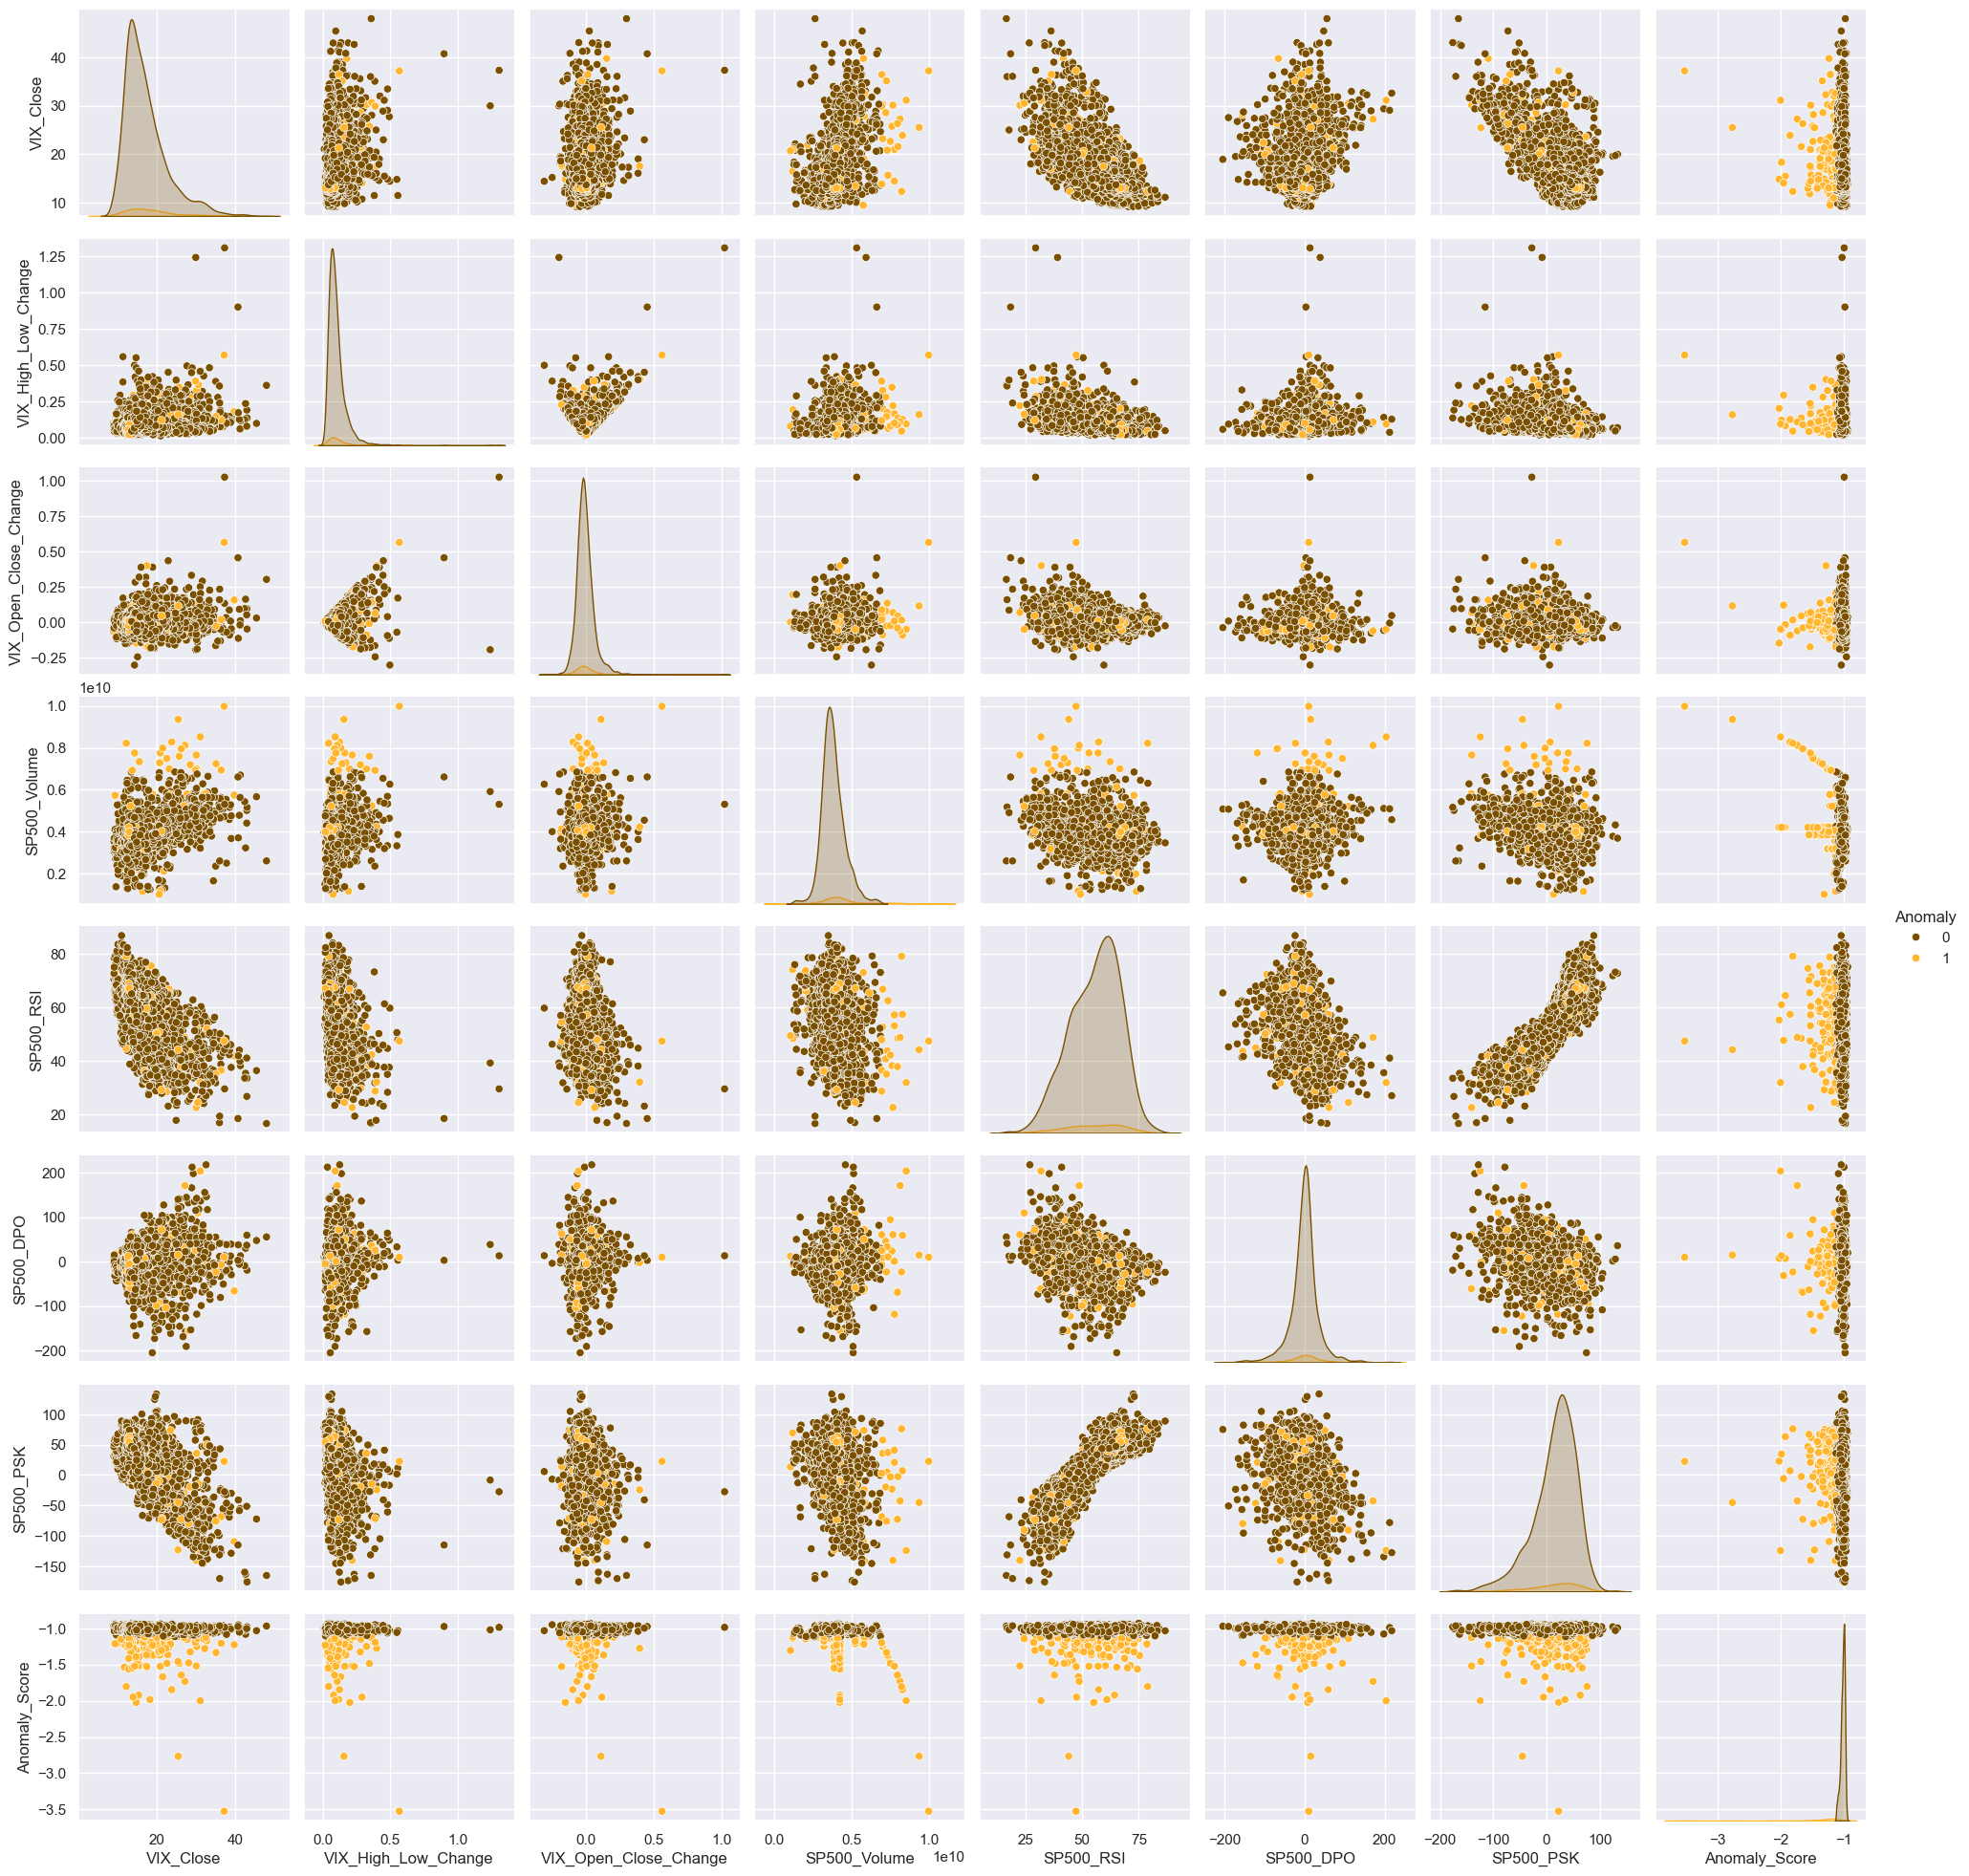

In [ ]:
# pairplot with anomaly scores
sns.set(style="darkgrid")
palette = {1: '#ffb62e', 0: "#7a4f00"}
sns.pairplot(df_copy2, hue='Anomaly', palette=palette)

Finally, we use the pairplot function again to create a grid of plots showing the relationships between different variables, with anomalies plotted in a different color. The anomalies are shown in the lighter orange color, with the remaining points represented by the brown markers.

In [ ]:
from scipy.stats import binomtest

# Calculate the p-value using binomtest
lof_p_value = binomtest(lof_flips, lof_anomalies, 0.5).pvalue

# Conduct a hypothesis test on the Isolation Forest to determine if the anomalies are statistically significant compared to 50/50 chance
# Calculate the p-value using binomtest
iso_p_value = binomtest(iso_flips, iso_anomalies, 0.5).pvalue

#print flips for both
print(f'LOF flips: {lof_flips} out of {lof_anomalies} anomalies')
print(f'Isolation Forest flips: {iso_flips} out of {iso_anomalies} anomalies')

print(f'\nLOF p-value: {lof_p_value}')
print(f'Isolation Forest p-value: {iso_p_value}')

if lof_p_value < 0.05:
    print('\nThe Local Outlier Factor anomalies are statistically significant')
else:
    print('The Local Outlier Factor anomalies are not statistically significant')

if iso_p_value < 0.05:
    print('\nThe Isolation Forest anomalies are statistically significant')
else:
    print('The Isolation Forest anomalies are not statistically significant')



LOF flips: 93 out of 155 anomalies
Isolation Forest flips: 92 out of 155 anomalies

LOF p-value: 0.015693618723720132
Isolation Forest p-value: 0.024197878749948425

The Local Outlier Factor anomalies are statistically significant

The Isolation Forest anomalies are statistically significant


To evaluate the results of our two models, we perform a statistical significance test using the binomial test (binomtest) for the anomalies detected by LOF and IF models. We also calculate the p-value to determine if the number of observed flips (price movement reversals) in anomalies significantly deviates from what would be expected by chance (50/50 chance).

Both P-values calculated by the two models are less than 0.05, demonstrating statistical significance. This demonstrates that both anomaly detection models are identify significant changes in stock price movements, specifically in price flips from anomalies, beyond what would be expected by random chance.

## 5. Create the ML Models

First we will train a Classifier on the Isolation Forest model

In [ ]:
# keep original df
df_iso_total = df_iso.copy()
# only keep the anomalies
df_iso = df_iso[df_iso['anomaly'] == -1]

# append flip column to df_iso
df_iso['Flip'] = anomaly_filtered_iso['Flip']

# drop the anomaly columna
df_iso = df_iso.drop(columns=['anomaly'])

df_iso

VIX_Close  VIX_High_Low_Change  VIX_Open_Close_Change  \
Date                                                                
2011-02-18  16.430000             0.088160              -0.009644   
2011-03-01  21.010000             0.191719               0.191719   
2011-03-16  29.400000             0.301165               0.192698   
2011-08-04  31.660000             0.319210               0.288563   
2011-08-05  32.000000             0.425200               0.123596   
...               ...                  ...                    ...   
2023-12-14  12.480000             0.076013               0.043478   
2023-12-15  12.280000             0.044130               0.013201   
2023-12-19  12.530000             0.021898              -0.005556   
2024-03-15  14.410000             0.098303               0.005583   
2024-04-12  17.809999             0.287726               0.194500   

            SP500_Volume  SP500_RSI  SP500_DPO   SP500_PSK  Anomaly_Score  \
Date                                                                        
2011-02-18    1162310000  74.001718  -6.192523   69.223115       0.068132   
2011-03-01    1180420000  48.247686   8.771533   17.765753       0.049978   
2011-03-16    5833000000  33.495007  -6.129535  -44.866312       0.012032   
2011-08-04    4266530000  23.990977  19.084967 -106.083661      -0.060238   
2011-08-05    5454590000  23.903961  44.266052 -104.961104      -0.054377   
...                  ...        ...        ...         ...            ...   
2023-12-14    6314040000  79.046942 -29.977905   85.403168       0.029229   
2023-12-15    8218980000  78.953601 -23.305664   76.012465       0.008535   
2023-12-19    4026970000  82.184452 -43.702197   85.367248       0.054780   
2024-03-15    7753670000  57.043471   0.718604   40.860024       0.101350   
2024-04-12    1402821000  44.193448  49.974707    1.919304       0.003560   

            Flip  
Date              
2011-02-18     1  
2011-03-01     1  
2011-03-16     1  
2011-08-04     0  
2011-08-05     0  
...          ...  
2023-12-14     1  
2023-12-15     1  
2023-12-19     1  
2024-03-15     1  
2024-04-12     0  

[155 rows x 9 columns]

In this cell, we prepare the data for model training by copying the original DataFrame df_iso to df_iso_total for backup, filtering df_iso to retain only anomaly rows, adding a 'Flip' column from another DataFrame as the target variable, and then dropping the 'anomaly' column.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

#train a supervised learning moduel with the iso anomalies predict the flip column 0 or 1
X = df_iso.drop(columns=['Flip'])
y = df_iso['Flip']


# Define the model
model = RandomForestClassifier(random_state=42)

# Define the hyperparameters to test
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='precision', cv=5, n_jobs=-1)

# Fit the model
grid_search.fit(X, y)

# Print the best parameters and the best precision
print("Best parameters:", grid_search.best_params_)

# Get the best model
best_model = grid_search.best_estimator_

# Predict using the best model
y_pred = best_model.predict(X)

# Generate and print the classification report
report = classification_report(y, y_pred)
print(report)



Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
              precision    recall  f1-score   support

           0       0.95      0.86      0.90        63
           1       0.91      0.97      0.94        92

    accuracy                           0.92       155
   macro avg       0.93      0.91      0.92       155
weighted avg       0.92      0.92      0.92       155



We train our model and use GridSearchCV to find the best hyperparameters from the specified param_grid. After training, the best parameters are displayed, and the model's performance is evaluated using the same data, producing a classification report.

After our analysis, we can see that our best classifier was able to predict with 95% accuracy if the anomaly would result in a next day price flip.

In [ ]:
y_df = y.to_frame()
# add y_pred to the dataframe
y_df['y_pred'] = y_pred

# if y = y_pred put 1 else put 0
y_df['Correct'] = np.where(y_df['Flip'] == y_df['y_pred'], 1, 0)

# merge the dataframes based on the index
df_iso_total_merged = df_iso_total.join(y_df['Correct'], how='left')

Here, we analyze the prediction results by comparing them to the actual values, marking each prediction as correct or incorrect, and then merging these results with the original DataFrame for further evaluation or visualization.

In [ ]:
# plot anomaly scores against the sp500 change price and when correct = 1 make the marker green else red
pl.io.templates.default = "plotly_dark"
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_iso_total_merged.index, y=sp500_prices2['PCT_Change'], mode='lines', name='Normal', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=df_iso_total_merged[df_iso_total_merged['Correct'] == 1].index, y=sp500_prices['PCT_Change'][df_iso_total_merged['Correct'] == 1], mode='markers', name='Correct', marker=dict(color='green')))
fig.add_trace(go.Scatter(x=df_iso_total_merged[df_iso_total_merged['Correct'] == 0].index, y=sp500_prices['PCT_Change'][df_iso_total_merged['Correct'] == 0], mode='markers', name='Incorrect', marker=dict(color='red')))
fig.update_layout(title='S&P 500 Anomalies using Isolation Forest', xaxis_title='Date', yaxis_title='Percent Change', legend_title="Type")
fig.show()


This graph demonstrates every time our ML model accurately predicted if the anomaly would flip or not indicated by Green for predicted and Red for didn't

Next, we will train a Classifier on the Local Outlier Factor model

In [ ]:
# keep original df
df_lof_total = df_lof.copy()
# only keep the anomalies
df_lof = df_lof[df_lof['Anomaly'] == 1]

# append flip column to df_lof
df_lof['Flip'] = anomaly_filtered_lof['Flip']

# drop the anomaly columns
df_lof = df_lof.drop(columns=['Anomaly'])

df_lof

VIX_Close  VIX_High_Low_Change  VIX_Open_Close_Change  \
Date                                                                
2011-02-02  17.299999             0.032407              -0.029181   
2011-02-11  15.690000             0.063023              -0.050817   
2011-02-18  16.430000             0.088160              -0.009644   
2011-03-01  21.010000             0.191719               0.191719   
2011-03-02  20.700001             0.077472              -0.001447   
...               ...                  ...                    ...   
2024-03-15  14.410000             0.098303               0.005583   
2024-03-20  13.040000             0.089162              -0.057122   
2024-03-21  12.920000             0.054839              -0.004622   
2024-03-27  12.780000             0.053713              -0.026657   
2024-03-28  13.010000             0.020249               0.006187   

            SP500_Volume  SP500_RSI  SP500_DPO  SP500_PSK  Anomaly_Score  Flip  
Date                                                                            
2011-02-02    4098260000  63.898784   8.924017  49.440345      -1.150335     1  
2011-02-11    4219300000  71.324668  -1.437463  61.688613      -1.514418     0  
2011-02-18    1162310000  74.001718  -6.192523  69.223115      -1.137874     1  
2011-03-01    1180420000  48.247686   8.771533  17.765753      -1.121684     1  
2011-03-02    1025000000  49.241908  11.898956  13.314638      -1.306703     0  
...                  ...        ...        ...        ...            ...   ...  
2024-03-15    7753670000  57.043471   0.718604  40.860024      -1.523548     1  
2024-03-20    4064850000  67.398835 -46.385034  63.013165      -1.141473     0  
2024-03-21    4207730000  68.756820 -28.000171  54.910581      -1.416015     1  
2024-03-27    3850500000  66.434927  12.601538  58.806017      -1.252660     0  
2024-03-28    3998270000  66.983291  -5.262427  54.324013      -1.232771     1  

[155 rows x 9 columns]

In [ ]:
#train a supervised learning moduel with the lof anomalies predict the flip column 0 or 1
X = df_lof.drop(columns=['Flip'])
y = df_lof['Flip']

# Define the model
model = RandomForestClassifier(random_state=42)

# Define the hyperparameters to test
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='precision', cv=5, n_jobs=-1)

# Fit the model
grid_search.fit(X, y)

# Print the best parameters and the best precision
print("Best parameters:", grid_search.best_params_)

# Get the best model
best_model = grid_search.best_estimator_

# Predict using the best model
y_pred = best_model.predict(X)

# Generate and print the classification report
report = classification_report(y, y_pred)
print(report)

Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 10}
              precision    recall  f1-score   support

           0       1.00      0.89      0.94        62
           1       0.93      1.00      0.96        93

    accuracy                           0.95       155
   macro avg       0.97      0.94      0.95       155
weighted avg       0.96      0.95      0.95       155



Once again, we train our model and  evaluate the model's performance, producing a classification report.

After our analysis, we can see that our best classifier was able to predict with 95% accuracy if the anomaly would result in a next day price flip.

In [ ]:
y_df = y.to_frame()
# add y_pred to the dataframe
y_df['y_pred'] = y_pred

# if y = y_pred put 1 else put 0
y_df['Correct'] = np.where(y_df['Flip'] == y_df['y_pred'], 1, 0)

# merge the dataframes based on the index
df_lof_total_merged = df_lof_total.join(y_df['Correct'], how='left')

Again, we analyze the prediction and merge these results with the original DataFrame.

In [ ]:
# plot anomaly scores against the sp500 change price and when correct = 1 make the marker green else red
pl.io.templates.default = "plotly_dark"
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_lof_total_merged.index, y=sp500_prices2['PCT_Change'], mode='lines', name='Normal', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=df_lof_total_merged[df_lof_total_merged['Correct'] == 1].index, y=sp500_prices['PCT_Change'][df_lof_total_merged['Correct'] == 1], mode='markers', name='Correct', marker=dict(color='green')))
fig.add_trace(go.Scatter(x=df_lof_total_merged[df_lof_total_merged['Correct'] == 0].index, y=sp500_prices['PCT_Change'][df_lof_total_merged['Correct'] == 0], mode='markers', name='Incorrect', marker=dict(color='red')))
fig.update_layout(title='S&P 500 Anomalies using LOF', xaxis_title='Date', yaxis_title='Percent Change', legend_title="Type")
fig.show()

This graph demonstrates every time our ML model accurately predicted if the anomaly would flip or not indicated by Green for predicted and Red for didn't